In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
home_folder = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
# we need to coordinates file to access the corner points - glamf/gphif
model_mask_file = home_folder + 'GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values

# tracer locations
lats_new=mask_ds['nav_lat'].values
lons_new=mask_ds['nav_lon'].values


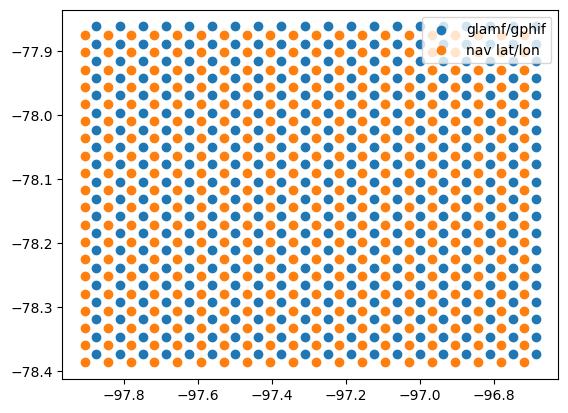

In [3]:
x=mask_ds['glamf']
y=mask_ds['gphif']

# get the mask values of the corner points
c=mask_ds['tmask'][:]
fig=plt.figure()
ax=plt.axes()

ax.scatter(x[0,:20,:20],y[0,:20,:20],label='glamf/gphif')
ax.scatter(mask_ds['nav_lon'][:20,:20],mask_ds['nav_lat'][:20,:20], label='nav lat/lon')
ax.legend()

<h4> Given a delta value- resolution of particles to be relased across a regular grid, compute the lats and lons of release points. \n Benguela Upwelling region lies between 10E-20E and 35S-20S ().

In [4]:
# Only upwelling region: (961, 641), 0.0625/4: #n: 370831
left_lon = 10.0
right_lon = 20.0
top_lat = -15.0
bottom_lat = -35.0

# extra region- FTLE: (1601, 1025), 0.0625/4 #n 1m
# left_lon = 10
# right_lon = 20
# top_lat = -15
# bottom_lat = -35

# Test region : near Cape Cauldron
# left_lon = 17.5
# right_lon = 19
# top_lat = -32.5
# bottom_lat = -34.5

res=32
delta= 1/res

lons = np.arange(left_lon, right_lon + delta, delta)
lats = np.arange(bottom_lat, top_lat + delta, delta)
regions_lons, regions_lats = np.meshgrid(lons, lats)
print(regions_lons.shape)
print(delta)

(641, 321)
0.03125


In [5]:
points = list(zip(regions_lons.flatten(), regions_lats.flatten()))
release_lons, release_lats = zip(*points)
print(len(release_lons))

205761


<h4>griddata function doesnt work well for curvilinear data - hence the masking related issues.

In [6]:
land_val_release = griddata((lons_new.ravel(), lats_new.ravel()), mask_land[0,0,:,:].ravel(),
                            (regions_lons, regions_lats), method='nearest', fill_value=0)     # Method 1- improved masking with t locations- nav_lat and nav_lon

bool_mask = land_val_release.astype(bool)
ocean_lons = regions_lons[bool_mask]
ocean_lats = regions_lats[bool_mask]
len(ocean_lats)

104640

In [7]:
# np.savez_compressed('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_cropped_boolmask_1ov{0}_{1}x_{2}ygrid.npz'.format(res, regions_lons.shape[0], regions_lons.shape[1]), mask=bool_mask, lons=regions_lons, lats=regions_lats)

# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_1601x1025.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

In [8]:
locations = pd.DataFrame(data=[ocean_lons, ocean_lats]).T
locations.columns=['Longitude', 'Latitude']
locations.to_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_release_points_1ov{0}_{1}x_{2}ygrid.csv'.format(res, regions_lons.shape[0], regions_lons.shape[1]),
        index=False, header=True, sep=',')

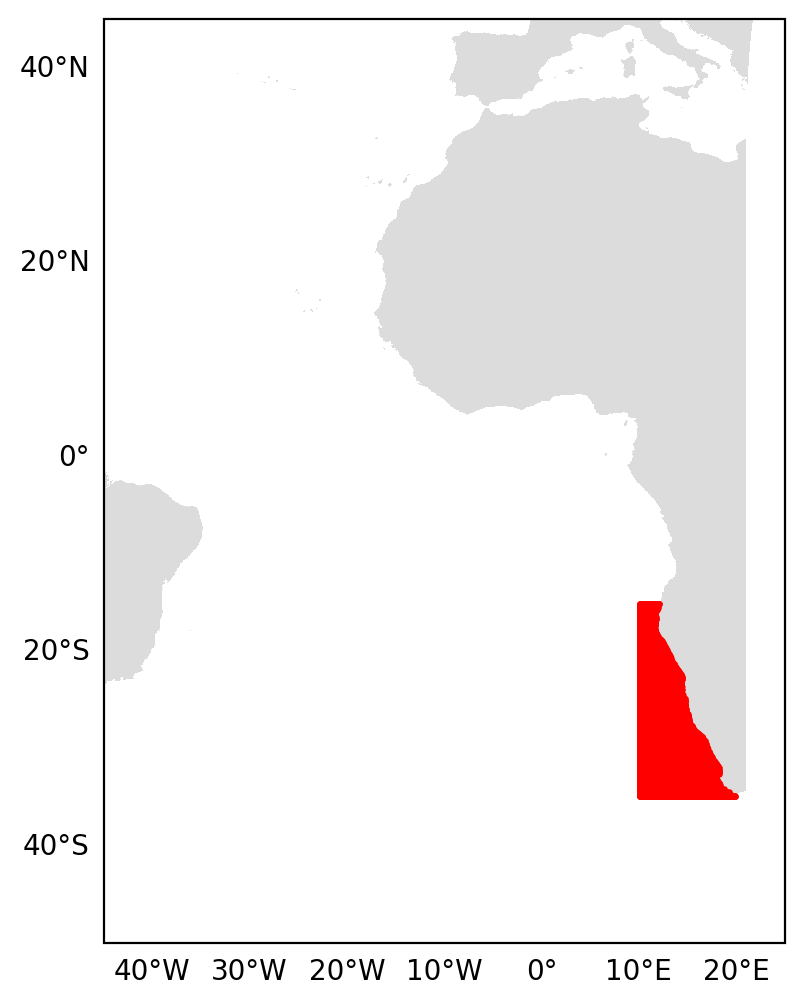

In [9]:

custom_size=10
fig = plt.figure(figsize=(5,6), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
# ax.add_feature(cfeature.COASTLINE)
colormap = clr.ListedColormap(['gainsboro', 'white'])
ax.pcolormesh(mask_lon[0, :,:], mask_lat[0, :,:], mask_land[0,0, 1:,1:], cmap=colormap)

ax.set_xlim(-45, 25)
ax.set_ylim(-50, 45)
# ax.set_xlim(18.5, 18.8)
# ax.set_ylim(-34.5, -34)

# ax.set_xlim(left_lon,right_lon)
# ax.set_ylim(bottom_lat, top_lat)
ax.scatter(ocean_lons, ocean_lats, s=0.1, c="red")
plt.show()

Zoom In

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:535: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:535: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:508: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/cartopy

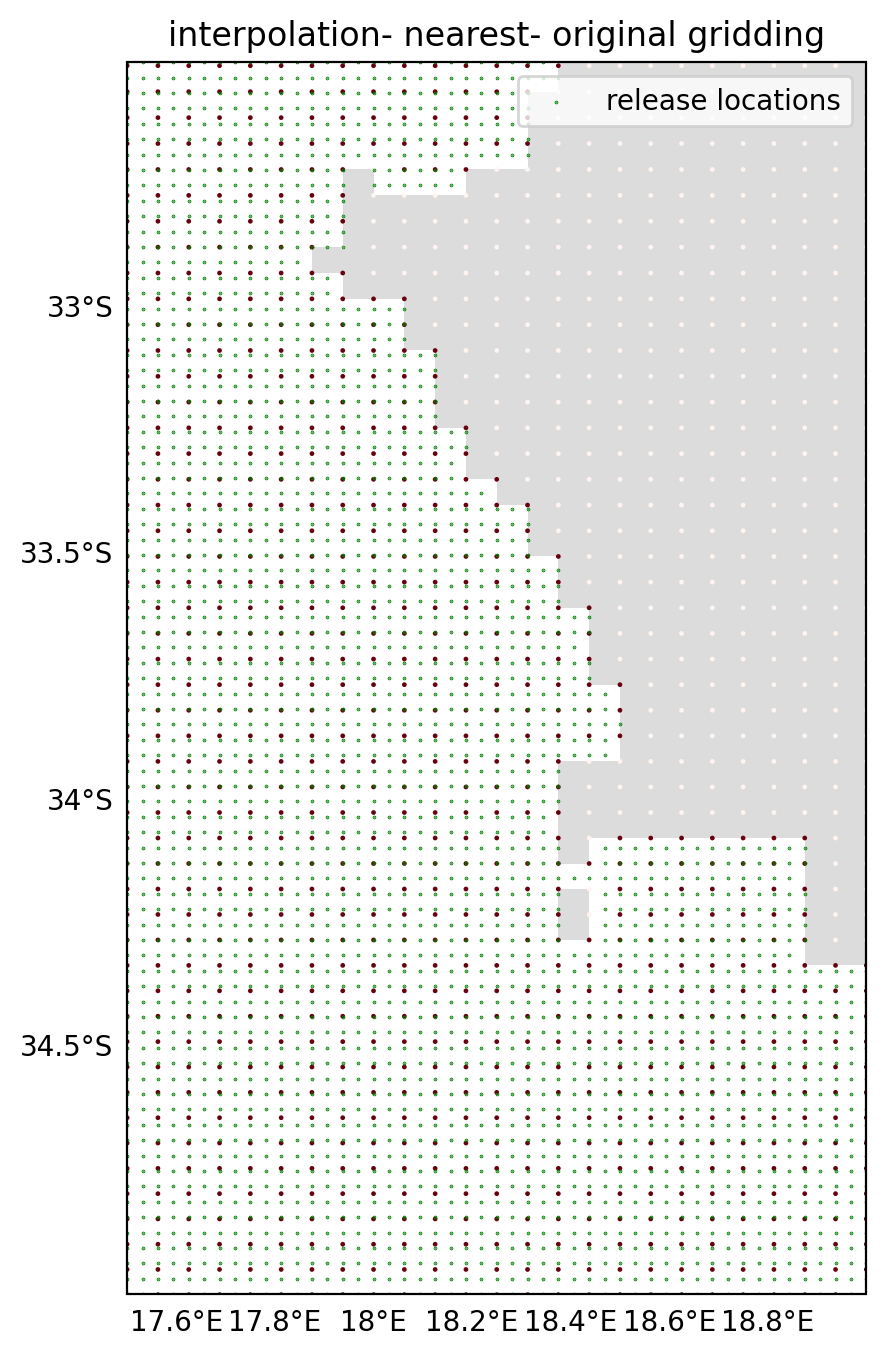

In [10]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("interpolation- nearest- original gridding")
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],c=mask_land[0,0, 1249:1750, 1499:], cmap=plt.cm.Reds, s=0.5)

ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

ax.scatter(ocean_lons, ocean_lats, s=0.1, c="green", label='release locations')
plt.legend()
plt.show()

<h3> Run a test simulation to sample u, v at the release locations

In [12]:
from datetime import timedelta, datetime, date
from parcels import Field, FieldSet, ParticleSet, JITParticle, Variable
from glob import glob
import pandas as pd
import numpy as np

data_path = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
project_data_path = '/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/'
mesh_mask = data_path + 'GLOB16L98_mesh_mask_atlantic.nc'

# Choose a random date
simulation_start = datetime(2011, 6, 1, 12, 0, 0)  

ufiles = sorted(glob(data_path + 'ROMEO.01_1d_uo_{0}{1}0*_grid_U.nc'.format(simulation_start.strftime("%Y"),simulation_start.strftime("%m"))))
vfiles = sorted(glob(data_path + 'ROMEO.01_1d_vo_{0}{1}0*_grid_V.nc'.format(simulation_start.strftime("%Y"),simulation_start.strftime("%m"))))
wfiles = sorted(glob(data_path + 'ROMEO.01_1d_wo_{0}{1}0*.nc'.format(simulation_start.strftime("%Y"),simulation_start.strftime("%m")))) 

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
            'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles}}

variables = {'U': 'uo',
            'V': 'vo'}

dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}
min_ind, max_ind = 5, 7 # for release depth z= 5 m
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, indices={'depth': range(min_ind, max_ind), 'lon': range(0,1903), 'lat': range(0,1877)}, chunksize=False) 

coords = pd.read_csv(project_data_path + 'Benguela_release_points_1ov32_641x_321ygrid.csv')
release_depth = 5

depth_arg = [release_depth for i in range(len(coords['Longitude']))]

class SampleParticle(JITParticle):
    land = Variable("land", dtype=np.int32, initial=0)

pset = ParticleSet.from_list(fieldset=fieldset, 
                            pclass=SampleParticle,
                            lon=coords['Longitude'],
                            lat=coords['Latitude'],
                            depth=depth_arg,
                            time=simulation_start)
pset.populate_indices()                            
output_file = pset.ParticleFile(name="sample_output.zarr",                               
                                outputdt=timedelta(hours=1))
def SampleVel_correct(particle, fieldset, time):
    u, v = fieldset.UV[particle]
    if u ==0.0 and v==0.0:
        particle.land = 1


pset.execute(SampleVel_correct,                
            runtime=timedelta(hours=1),
            dt= timedelta(hours=1),                       
            output_file=output_file)
            # recovery={FieldOutOfBoundError: util.delete_particle})


INFO: Output files are stored in sample_output.zarr.
100%|██████████| 3600.0/3600.0 [00:01<00:00, 2057.39it/s]


<h3> still some particles remain on land -after filtering- 

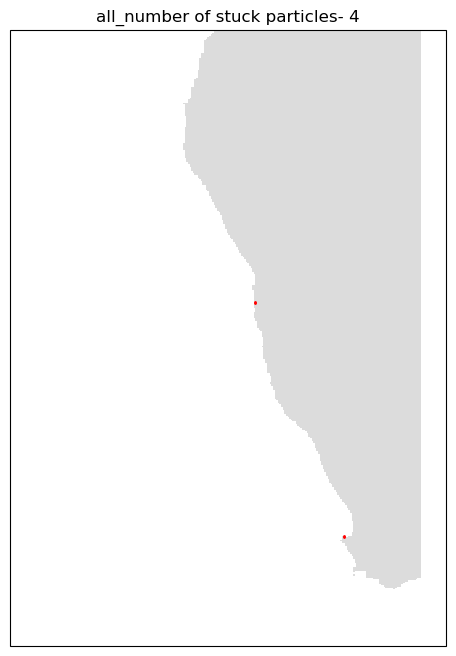

In [7]:
# test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/2D/TestBenguelaUpwR_1ov32_641x321res_Jul2017_1z_15days.zarr')

test_ds=xr.open_zarr('sample_output.zarr')

stuck_ids = np.where(test_ds.land[:,0])[0]

fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

ax.set_xlim(5, 22)
ax.set_ylim(-37, -13)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids), np.take(test_ds.lat[:,-1],stuck_ids), s=1, c="red")
plt.show()

In [8]:
remove_indices = np.where(test_ds.land[:,0]==1)
remove_indices

(array([20426, 20687, 78794, 78941]),)

<p> Remove the particles that remain stuck at 5 m.

In [19]:
if remove_indices[0].size:
    new_lons = np.delete(ocean_lons,remove_indices)
    new_lats = np.delete(ocean_lats,remove_indices)
len(new_lons), len(new_lats)

(104636, 104636)

In [20]:
locations = pd.DataFrame(data=[new_lons, new_lats]).T
locations.columns=['Longitude', 'Latitude']
locations.to_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_release_points_1ov{0}_{1}x_{2}ygrid.csv'.format(res, regions_lons.shape[0], regions_lons.shape[1]),
        index=False, header=True, sep=',')

In [19]:
ocean_locations= np.where(bool_mask==True)

for r in remove_indices:
    x= ocean_locations[0][r]
    y=ocean_locations[1][r]
    bool_mask[x,y]=False



In [21]:
np.savez_compressed('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_cropped_boolmask_1ov{0}_{1}x_{2}ygrid.npz'.format(res, regions_lons.shape[0], regions_lons.shape[1]), mask=bool_mask, lons=regions_lons, lats=regions_lats)


<h5>Conclusion:
<p>
Four particles that don't have any velocity fields in the test simulation , i.e., they are on land are removed. Now #104,636 partciles released per simulation.